In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [361]:
raw = pd.read_csv('datasets/viz_eda.csv')

In [362]:
raw.head()

,date,series_id,value
0,2000-01-03,AAA10Y,-0.925802
1,2000-01-04,AAA10Y,-0.856570
2,2000-01-05,AAA10Y,-0.948880
3,2000-01-06,AAA10Y,-0.971957
4,2000-01-07,AAA10Y,-0.925802


In [363]:
df = raw.pivot(index = "date", columns = "series_id", values = "value")
df.fillna(method='ffill')

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,SOFR,SOFRVOL,SP500,T10YIE,TEDRATE,TLAACBW027NBOG,TLBACBW027NBOG,TSIFRGHT,UNRATE,WLEMUINDXD
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.925802,NaN,-1.250124,NaN,NaN,NaN,NaN,NaN,1.367135,-1.168570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.096708
2000-01-04,-0.856570,NaN,-1.209737,NaN,NaN,NaN,NaN,NaN,1.367259,-1.074193,...,NaN,NaN,NaN,NaN,0.875030,NaN,NaN,NaN,NaN,1.846081
2000-01-05,-0.948880,NaN,-1.277049,NaN,NaN,NaN,NaN,NaN,1.367135,-1.058259,...,NaN,NaN,NaN,NaN,0.824964,-1.585523,-1.568125,NaN,NaN,-0.374432
2000-01-06,-0.971957,NaN,-1.277049,NaN,NaN,NaN,NaN,NaN,1.367010,-1.065000,...,NaN,NaN,NaN,NaN,0.900063,-1.585523,-1.568125,NaN,NaN,-0.399492
2000-01-07,-0.925802,NaN,-1.236662,NaN,NaN,NaN,NaN,NaN,1.366637,-1.083385,...,NaN,NaN,NaN,NaN,0.975162,-1.585523,-1.568125,NaN,NaN,-0.379760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,-0.348868,-0.579975,-0.644321,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,-1.435631,-0.416967,2.630985,0.454880,-0.677009,2.145295,2.232997,1.98585,4.634418,1.861077
2021-02-09,-0.348868,-0.579975,-0.630858,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,-1.404802,-0.553170,2.624300,0.454880,-0.677009,2.145295,2.232997,1.98585,4.634418,1.861077
2021-02-10,-0.325791,-0.579975,-0.617396,0.267132,0.918991,-1.326439,0.449925,-1.372066,-0.890475,-0.016433,...,-1.394526,-0.675036,2.622230,0.430655,-0.677009,2.145295,2.232997,1.98585,4.634418,1.861077


## Technical Indecator

In [364]:
def get_technical(sp500):
    tech = sp500.copy()
    tech['ma7'] = tech["SP500"].rolling(7).mean()
    tech['ma21'] = tech["SP500"].rolling(21).mean()
    tech['26ema'] = tech["SP500"].ewm(span=26).mean()
    tech['12ema'] = tech["SP500"].ewm(span=12).mean()
    tech['MACD'] = (tech['12ema']-tech['26ema'])
    tech['20sd'] = tech["SP500"].rolling(20).std()
    tech['upper_band'] = tech['ma21'] + (tech['20sd']*2)
    tech['lower_band'] = tech['ma21'] - (tech['20sd']*2)
    tech['ema'] = tech["SP500"].ewm(com=0.5).mean()
    tech['momentum'] = tech["SP500"].diff()
    tech = tech.drop(columns = "SP500").shift(periods=1)
    tech["value"] = sp500["SP500"]
    return tech[["ma7","ma21","26ema","12ema","MACD","ema","momentum"]]

In [256]:
train = pd.read_csv("datasets/observations_train.csv")
train = train[train["series_id"] == "SP500"]

In [257]:
test = pd.read_csv("datasets/observations_test.csv")
test = test[test["series_id"] == "SP500"]

In [298]:
merged = pd.concat([train,test])
merged = merged.pivot(index = "date", columns = "series_id", values = "value").dropna()

In [299]:
tech = get_technical(merged)

In [300]:
tech.to_csv("datasets/technical.csv")

<AxesSubplot:xlabel='date'>

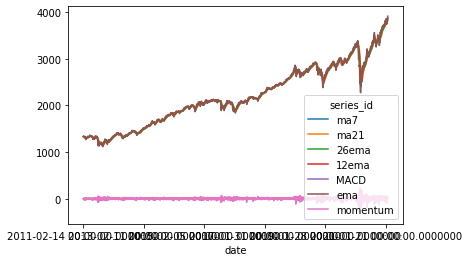

In [301]:
tech.plot()

## Fourier transforms 

In [306]:
import numpy as np
import pylab as pl
from numpy import fft

In [344]:
def fourierExtrapolation(x, n_predict, n_harm):
    n = x.size            
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [323]:
len(merged)

2516

In [347]:
ft = merged.copy()

In [348]:
for harm in [3,5,10,100]:
    pred = []
    for i in range(2,len(merged)):
        pred.append(fourierExtrapolation(merged.values[max(0,i - 1000) :i,0],1, harm)[-1])
    ft["ft" + str(harm)] = [np.NaN,np.NaN] + pred

In [350]:
ft

series_id,SP500,ft3,ft5,ft10,ft100
date,,,,,
2011-02-14 00:00:00.0000000,1332.32,NaN,NaN,NaN,NaN
2011-02-15 00:00:00.0000000,1328.01,NaN,NaN,NaN,NaN
2011-02-16 00:00:00.0000000,1336.32,1323.700000,1323.700000,1323.700000,1323.700000
2011-02-17 00:00:00.0000000,1340.43,1338.320000,1338.320000,1338.320000,1338.320000
2011-02-18 00:00:00.0000000,1343.01,1345.376000,1345.376000,1345.376000,1345.376000
...,...,...,...,...,...
2021-02-05 00:00:00.0000000,3886.83,3592.554306,3587.970671,3611.431566,3590.017641
2021-02-08 00:00:00.0000000,3915.59,3597.573981,3591.322835,3616.256460,3613.712825
2021-02-09 00:00:00.0000000,3911.23,3602.838326,3595.049064,3621.723071,3635.490488


In [355]:
ft.to_csv("datasets/FT.csv")

In [1]:
df = df.merge(ft.drop(columns = "SP500"), on= "date", how = "left")
df = df.merge(tech, on = "date", how = "left")
df["SP500_UNNORM"] = merged["SP500"]

NameError: name 'df' is not defined

In [ ]:
df.head()

In [ ]:
1/0

In [359]:
df.to_csv("all_features")

series_id,AAA10Y,ASEANTOT,BAA10Y,BUSAPPWNSAUS,BUSAPPWNSAUSYY,CBUSAPPWNSAUS,CBUSAPPWNSAUSYY,CUUR0000SA0R,DEXCHUS,DEXUSEU,...,ft5_y,ft10_y,ft100_y,ma7,ma21,26ema,12ema,MACD,ema,momentum
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-1.036107,NaN,-1.289859,NaN,NaN,NaN,NaN,NaN,1.219482,-1.152743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.967114,NaN,-1.250705,NaN,NaN,NaN,NaN,NaN,1.219600,-1.064182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,-1.059104,NaN,-1.315961,NaN,NaN,NaN,NaN,NaN,1.219482,-1.049231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-1.082102,NaN,-1.315961,NaN,NaN,NaN,NaN,NaN,1.219364,-1.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,-1.036107,NaN,-1.276807,NaN,NaN,NaN,NaN,NaN,1.219010,-1.072808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,-1.289080,NaN,-1.172398,NaN,NaN,NaN,NaN,NaN,-0.833333,-0.168226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-27,-1.312078,NaN,-1.198500,NaN,NaN,NaN,NaN,NaN,-0.817850,-0.148099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-28,-1.312078,NaN,-1.198500,NaN,NaN,NaN,NaN,NaN,-0.845979,-0.119346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], verbose=False)
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()